### Linear discriminant analysis from scratch

#### This notebook walks through the steps involved in LDA and the basics behind each calculation.

#### The notebook is built by follow the link: https://docs.google.com/document/d/1b-HoS9oQUtCOKpK_ZWPSr95suki-Ozo21N-Sj8X_Vps/edit

#### Iris dataset is used for this demonstration.

#### Load the libraries

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import numpy as np
import math

#### Load and read the dataset

In [2]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}


df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )

df.columns = [i for i,l in sorted(feature_dict.items())] + ['class label']

df.dropna(how = 'all', inplace = True)

df.tail()

,0,1,2,3,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


#### Transform class labels

In [5]:
X = df[[0,1,2,3]].values

y =df['class label'].values

enc = LabelEncoder()
#label_encoder = enc.fit(y)
y = enc.fit_transform(y) + 1

label_dict = {1: "Setosa", 2: 'Versicolor', 3:'Virginica'}

#### Plot the dataset


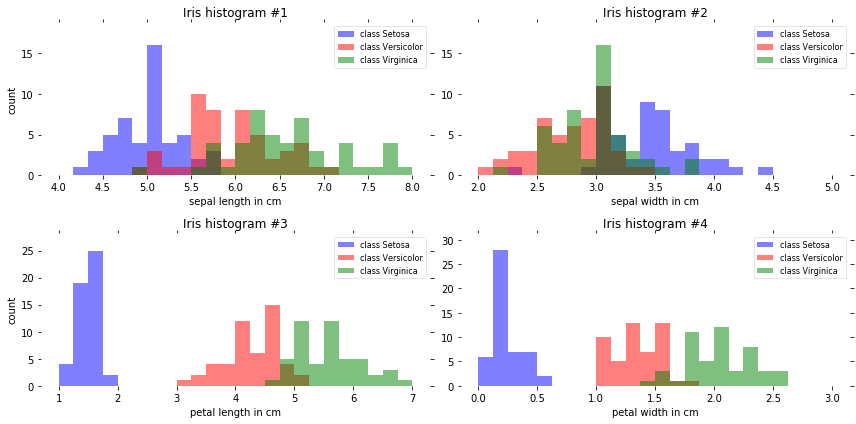

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()


#### From just looking at these simple graphical representations of the features, we can already tell that the petal lengths and widths are likely better suited as potential features two separate between the three flower classes. In practice, instead of reducing the dimensionality via a projection (here: LDA), a good alternative would be a feature selection technique. 

#### LDA assumes:
#### 1 - Normally distributed data
#### 2 - Features are statistically independent
#### 3 - Identical covariance matrices for each class

#### These assumptions are required only for LDA as classier. If LDA is used only for dimensionality reduction, the algorithm works reasonably well if the assumptions are violated.

#### Step 1 - Calculate the mean feature vector

In [9]:
np.set_printoptions(precision=4)

mean_vector = []
for i in range(1,4):
    mean_vector.append(np.mean(X[y==i], axis = 0))
    print("Mean vector class %s %s\n" %(i, mean_vector[i-1]))

Mean vector class 1 [5.006 3.418 1.464 0.244]

Mean vector class 2 [5.936 2.77  4.26  1.326]

Mean vector class 3 [6.588 2.974 5.552 2.026]



#### Step 2 - Calculate scatter matrices (both within class and between class)

In [11]:
# Within class scatter matrix
S_W = np.zeros((4,4))

for cl, mean_vec in zip(range(1,4), mean_vector):
    class_sc_mat = np.zeros((4,4))   # Make scatter matrix for every class
    for row in X[y==cl]:
        row, mean_vec =row.reshape(4,1), mean_vec.reshape(4,1)   # Make column vectors
        class_sc_mat += (row - mean_vec).dot((row -mean_vec).T)
    S_W += class_sc_mat
    
print("Within class scatter matrix: \n", S_W)

Within class scatter matrix: 
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


In [12]:
# Between class scatter matrix

overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 35.0564 -15.2395  96.07    39.9687]
 [-15.2395   6.6248 -41.7629 -17.3749]
 [ 96.07   -41.7629 263.2748 109.5321]
 [ 39.9687 -17.3749 109.5321  45.5694]]


#### Step 3 - Solving the generalized eigenvalue problem for the matrix SW(-1)SB

In [15]:
# Calculate eignevalues and eigenvectors

eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1) 
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.9308]
 [-0.1509]
 [ 0.2074]
 [ 0.2604]]
Eigenvalue 1: 0.00e+00

Eigenvector 2: 
[[-0.206 ]
 [-0.4039]
 [ 0.5553]
 [ 0.6972]]
Eigenvalue 2: 1.97e+01

Eigenvector 3: 
[[0.1461]
 [0.9796]
 [0.0483]
 [0.1292]]
Eigenvalue 3: 8.66e-16

Eigenvector 4: 
[[ 0.1477]
 [-0.2495]
 [-0.4458]
 [ 0.8469]]
Eigenvalue 4: -3.47e-15


#### Step 4 - Selecting linear discriminant for new feature subspace

In [16]:
# 1 - Sorting eigenvectors by decreasing eigenvalues

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

19.742424906926757
3.465028175567194e-15
8.658112840473277e-16
0.0


In [17]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 100.00%
eigenvalue 2: 0.00%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


#### The first eigenvector is by far the most informative. We won't lose any information if we form a 1D subspace feature.

In [18]:
# Choosing k eigenvectors with the largest eigenvalues
# Let's create a 2 dimensional subspace feature (4 x 2) projection matrix

W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[-0.206   0.1477]
 [-0.4039 -0.2495]
 [ 0.5553 -0.4458]
 [ 0.6972  0.8469]]


#### Step 5 - Transforming the dataset into the new subspace feature

In [22]:
#Y = X W

X_lda = X.dot(W)
print("Matrix shape:", X_lda.shape)


Matrix shape: (150, 2)


#### Plot the dataset in the new feature space

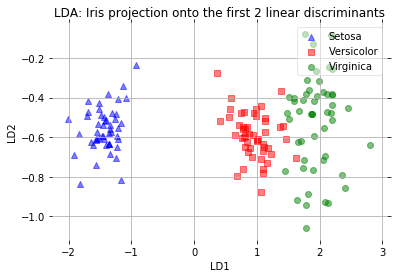

In [23]:
def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

In [26]:
def plot_scikit_lda(X, title):

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

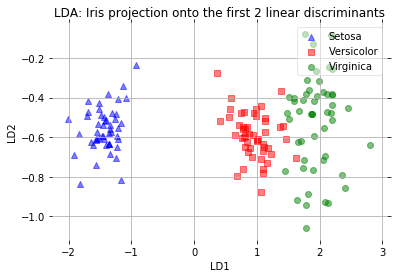

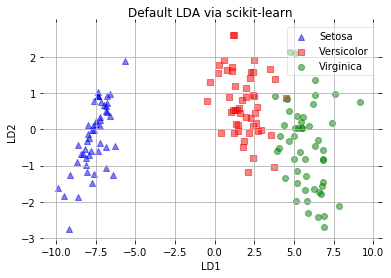

In [27]:
plot_step_lda()
plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')